Model unknown

  Variables:
    x : Size=72, Index={Kohle, GuD, Gasturbine}*{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
        Key                : Lower : Value              : Upper : Fixed : Stale : Domain
         ('Gasturbine', 0) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 1) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 2) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 3) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 4) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 5) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 6) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 7) :     0 :                0.0

AttributeError: 'Figure' object has no attribute 'tight'

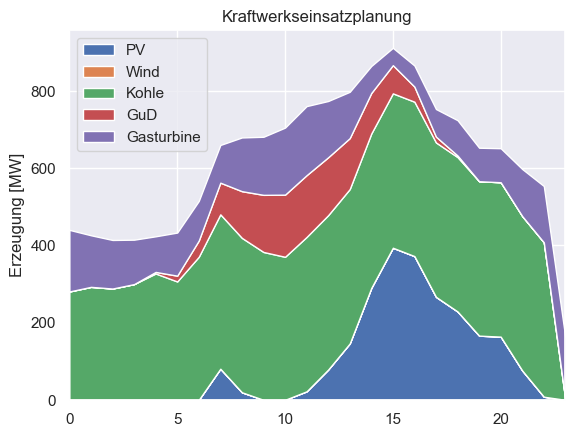

In [1]:
# Einlesen der Module
from pyomo.environ import *
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Zeitschritte und Parameter
T = 24
timesteps = np.arange(T)

c_CO2 = 80  # EUR/tCO2

thermalPlant = ['Kohle', 'GuD', 'Gasturbine']
power = {'Kohle': 600, 'GuD': 400, 'Gasturbine': 300}  # MW
efficiency = {'Kohle': 0.41, 'GuD': 0.58, 'Gasturbine': 0.4}
fuel_price = {'Kohle': 10, 'GuD': 30, 'Gasturbine': 30}  # EUR/MWhprim
emission_factor = {'Kohle': 0.35, 'GuD': 0.2, 'Gasturbine': 0.2}  # tCO2/MWhprim
MC = {}
emissions = {}
for n in thermalPlant:
    MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]
    emissions[n] = emission_factor[n] / efficiency[n]

# Daten laden, PV und Wind laden
df = pd.read_excel('Last_PV_Wind.xlsx')
wind = df['Wind 300 MW']
PV = df['PV 200 MW Sommer']
load = df['Last Sommer [MW]'] - df['Wind 300 MW'] - df['PV 200 MW Sommer']

# Speicherparameter
capacity = 600  # Speicher-Kapazität in MWh
eta_charge = 0.9  # Ladeeffizienz
eta_discharge = 0.9  # Entladeeffizienz
initial_SOC = 0  # Anfangsspeicherstand

# Pyomo Modell aufstellen
model = ConcreteModel()

model.x = Var(thermalPlant, timesteps, within=NonNegativeReals)
model.w_generate = Var(timesteps, within=NonNegativeReals)
model.w_pump = Var(timesteps, within=NonNegativeReals)
model.SOC = Var(timesteps, within=NonNegativeReals)

# Zielfunktion
model.obj = Objective(
    expr=sum(model.x[n, t] * MC[n] for n in thermalPlant for t in timesteps),
    sense=minimize
)

# Nebenbedingungen
def power_constraint_rule(model, n, t):
    return model.x[n, t] <= power[n]

model.power_con = Constraint(thermalPlant, timesteps, rule=power_constraint_rule)

def load_constraint_rule(model, t):
    return (sum(model.x[n, t] for n in thermalPlant) + wind.loc[t] + PV.loc[t] + model.w_generate[t]) == load.loc[t] + model.w_pump[t]

model.load_con = Constraint(timesteps, rule=load_constraint_rule)

def storage_balance_rule(model, t):
    if t == 0:
        return model.SOC[t] == initial_SOC
    else:
        return model.SOC[t] == model.SOC[t-1] + eta_charge * model.w_pump[t-1] - model.w_generate[t-1] / eta_discharge

model.storage_balance = Constraint(timesteps, rule=storage_balance_rule)

def storage_capacity_rule(model, t):
    return model.SOC[t] <= capacity

model.storage_capacity = Constraint(timesteps, rule=storage_capacity_rule)

def storage_initial_final_rule(model):
    return model.SOC[0] == model.SOC[T-1]

model.storage_initial_final = Constraint(rule=storage_initial_final_rule)

###Schattenvariable für Punkt c)###
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT_EXPORT)

opt = SolverFactory('gurobi')
opt_success = opt.solve(model)

model.display()

# get values of optimization variables
PowerThermal = pd.DataFrame(index=timesteps, columns=thermalPlant)
guDPower = np.empty(T, dtype=float)
gasPower = np.empty(T, dtype=float)
kohlePower = np.empty(T, dtype=float)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n, t].value
        guDPower[t] = PowerThermal.loc[t, 'GuD']
        gasPower[t] = PowerThermal.loc[t, 'Gasturbine']
        kohlePower[t] = PowerThermal.loc[t, 'Kohle']

# Berechnung der minimalen Kosten und der gesamten Emissionen
print()
totalMinCost = model.obj()
print("Gesamtkosten der Stromversorgung:", totalMinCost, "EUR")
totalEmissions = sum(model.x[n, t].value * emissions[n] for n in thermalPlant for t in timesteps)
print("Gesamte CO2 Emissionen", totalEmissions, "tCO2")

# plot
sns.set()
powerplants = {'Kohle', 'Gasturbine', 'GuD', 'PV', 'Wind'}
fig, ax = plt.subplots()
ax.stackplot(timesteps, kohlePower, gasPower, guDPower, PV, wind, labels=powerplants)
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='upper left')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight


